In [5]:
# Importing Libraries
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense 
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0 
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
from sklearn.metrics import accuracy_score
from keras.layers import Flatten
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

### Data Preprocessing and Augmentation

#### Rescale images to [0, 1] range.

In [6]:
# Set the base directory
lst = ['train','val']
for i in lst:
    base_dir = "C:/Users/conta/OneDrive/Desktop/Multiclass/data/" + i

    # List to store image metadata
    image_data = []

    # Loop through subfolders
    for subfolder in os.listdir(base_dir):
        subfolder_path = os.path.join(base_dir, subfolder)

        if os.path.isdir(subfolder_path):  # Check if it's a folder
            for file in os.listdir(subfolder_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter images
                    img_path = os.path.join(subfolder_path, file)
                    try:
                        img = Image.open(img_path)
                        image_data.append([img_path, subfolder, img.size[0], img.size[1], img.format])

                    except Exception as e:
                        print(f"Error processing {file}: {e}")


    # Convert to DataFrame
    df = pd.DataFrame(image_data, columns=["Filename", "Class", "Width", "Height", "Format"])

    # Save to CSV
    #csv_path = "/reports/" + i + "_image_details.csv"
    csv_path = os.path.join("reports", f"{i}_image_details.csv")

    df.to_csv(csv_path, index=False)
    print(f"CSV file saved at: {csv_path}")

CSV file saved at: reports\train_image_details.csv
CSV file saved at: reports\val_image_details.csv


In [7]:
train_df = pd.read_csv("C:/Users/conta/OneDrive/Desktop/Multiclass/reports/train_image_details.csv")
train_df

Filename                Class  \
0     C:/Users/conta/OneDrive/Desktop/Multiclass/dat...          animal fish   
1     C:/Users/conta/OneDrive/Desktop/Multiclass/dat...          animal fish   
2     C:/Users/conta/OneDrive/Desktop/Multiclass/dat...          animal fish   
3     C:/Users/conta/OneDrive/Desktop/Multiclass/dat...          animal fish   
4     C:/Users/conta/OneDrive/Desktop/Multiclass/dat...          animal fish   
...                                                 ...                  ...   
6220  C:/Users/conta/OneDrive/Desktop/Multiclass/dat...  fish sea_food trout   
6221  C:/Users/conta/OneDrive/Desktop/Multiclass/dat...  fish sea_food trout   
6222  C:/Users/conta/OneDrive/Desktop/Multiclass/dat...  fish sea_food trout   
6223  C:/Users/conta/OneDrive/Desktop/Multiclass/dat...  fish sea_food trout   
6224  C:/Users/conta/OneDrive/Desktop/Multiclass/dat...  fish sea_food trout   

      Width  Height Format  
0       256     256   JPEG  
1       256     256   JPEG  
2       256     256   JPEG  
3       256     256   JPEG  
4       256     256   JPEG  
...     ...     ...    ...  
6220    256     256   JPEG  
6221    256     256   JPEG  
6222    256     256   JPEG  
6223    256     256   JPEG  
6224    256     256   JPEG  

[6225 rows x 5 columns]

In [8]:
val_df = pd.read_csv("C:/Users/conta/OneDrive/Desktop/Multiclass/reports/val_image_details.csv")
val_df

Filename                Class  \
0     C:/Users/conta/OneDrive/Desktop/Multiclass/dat...          animal fish   
1     C:/Users/conta/OneDrive/Desktop/Multiclass/dat...          animal fish   
2     C:/Users/conta/OneDrive/Desktop/Multiclass/dat...          animal fish   
3     C:/Users/conta/OneDrive/Desktop/Multiclass/dat...          animal fish   
4     C:/Users/conta/OneDrive/Desktop/Multiclass/dat...          animal fish   
...                                                 ...                  ...   
1087  C:/Users/conta/OneDrive/Desktop/Multiclass/dat...  fish sea_food trout   
1088  C:/Users/conta/OneDrive/Desktop/Multiclass/dat...  fish sea_food trout   
1089  C:/Users/conta/OneDrive/Desktop/Multiclass/dat...  fish sea_food trout   
1090  C:/Users/conta/OneDrive/Desktop/Multiclass/dat...  fish sea_food trout   
1091  C:/Users/conta/OneDrive/Desktop/Multiclass/dat...  fish sea_food trout   

      Width  Height Format  
0       256     256   JPEG  
1       256     256   JPEG  
2       256     256   JPEG  
3       256     256   JPEG  
4       256     256   JPEG  
...     ...     ...    ...  
1087    256     256   JPEG  
1088    256     256   JPEG  
1089    256     256   JPEG  
1090    256     256   JPEG  
1091    256     256   JPEG  

[1092 rows x 5 columns]

In [9]:
Classes = train_df["Class"].unique()
Classes

array(['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat',
       'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel',
       'fish sea_food red_mullet', 'fish sea_food red_sea_bream',
       'fish sea_food sea_bass', 'fish sea_food shrimp',
       'fish sea_food striped_red_mullet', 'fish sea_food trout'],
      dtype=object)

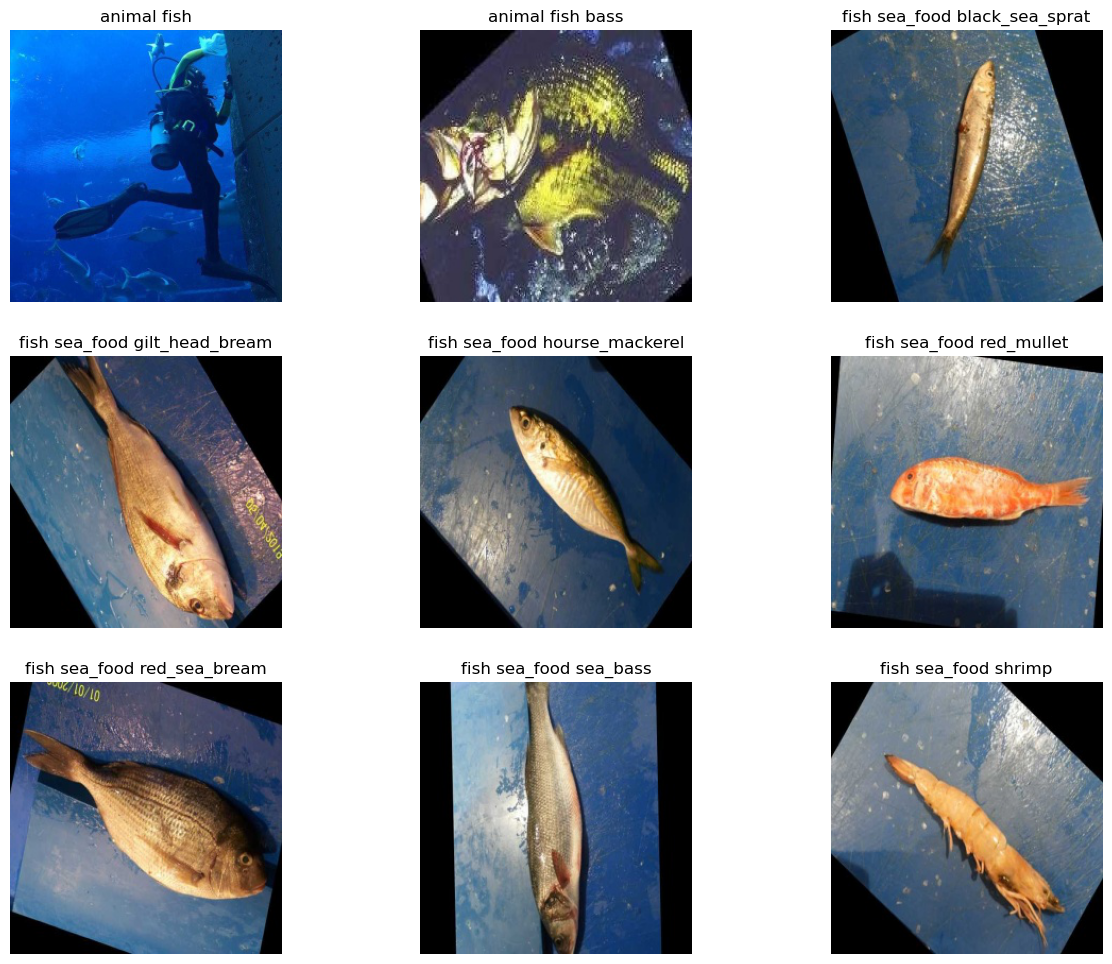

In [10]:
#DIR = "C:/Users/conta/OneDrive/Desktop/Multiclass/data/train"
plt.figure(figsize=(15,12))
for idx, cate in enumerate(Classes[:9]):  # Limit index to 9
    plt.subplot(3, 3, idx+1)  # Max index should be 9 (3x3)
    plt.imshow(plt.imread(train_df[train_df["Class"]==cate].iloc[0,0]))
    plt.title(cate)
    plt.axis('off')

#### Apply data augmentation techniques like rotation, zoom, and flipping to enhance model robustness.

In [10]:
# Define image size
img_size = (224, 224)

# Define directories for training and validation datasets
train_dir = "C:/Users/conta/OneDrive/Desktop/Multiclass/data/train"
val_dir = "C:/Users/conta/OneDrive/Desktop/Multiclass/data/val"

# Image Data Generator for Data Augmentation and Rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.


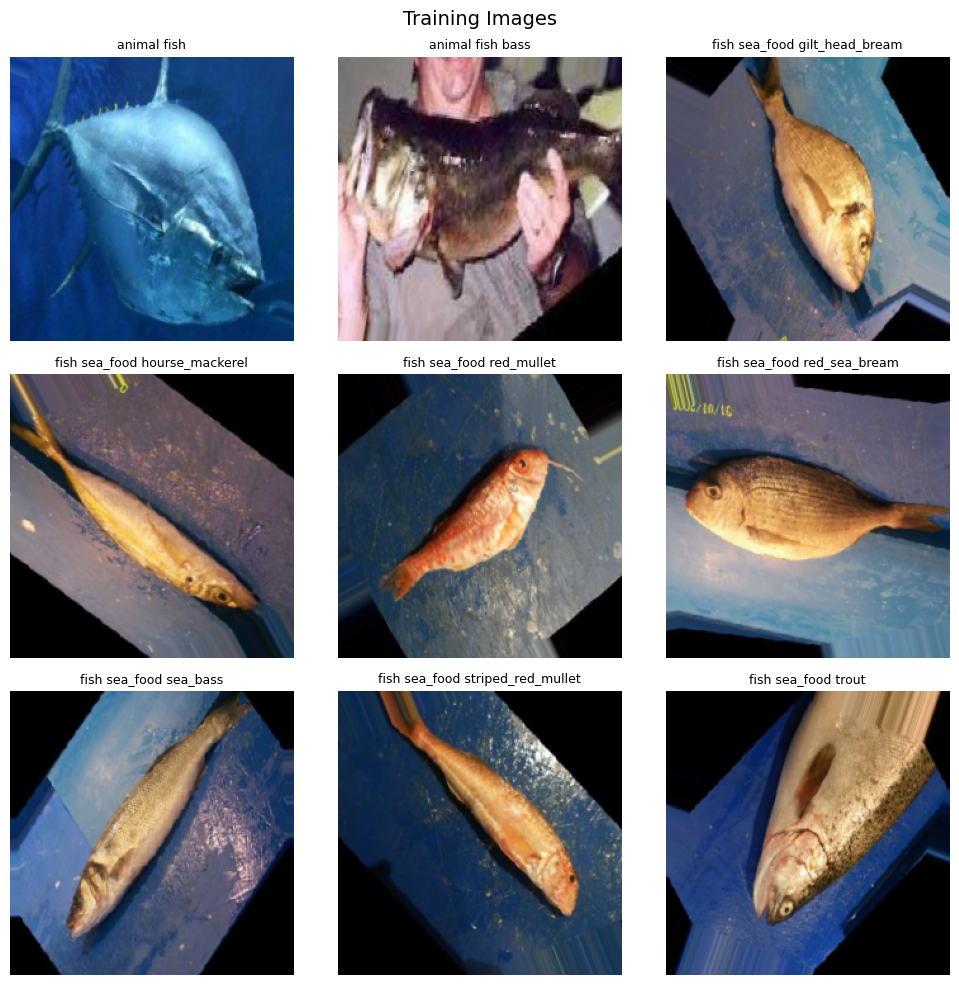

In [11]:
# Map index to class name
index_to_class = {v: k for k, v in train_generator.class_indices.items()}
num_classes = len(index_to_class)

# Limit to 9 classes for 3x3 display
max_display = min(9, num_classes)

# Dictionary to store one image per class
sample_images = {}

# Collect one image per class
for images, labels in train_generator:
    label_indices = np.argmax(labels, axis=1)

    for img, idx in zip(images, label_indices):
        if idx not in sample_images:
            sample_images[idx] = img
        if len(sample_images) == max_display:
            break
    if len(sample_images) == max_display:
        break

# Plot in 3x3 grid
plt.figure(figsize=(10, 10))
for i, (class_idx, image) in enumerate(sorted(sample_images.items())[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(index_to_class[class_idx], fontsize=9)
    plt.axis("off")

plt.suptitle("Training Images", fontsize=14)
plt.tight_layout()
plt.show()

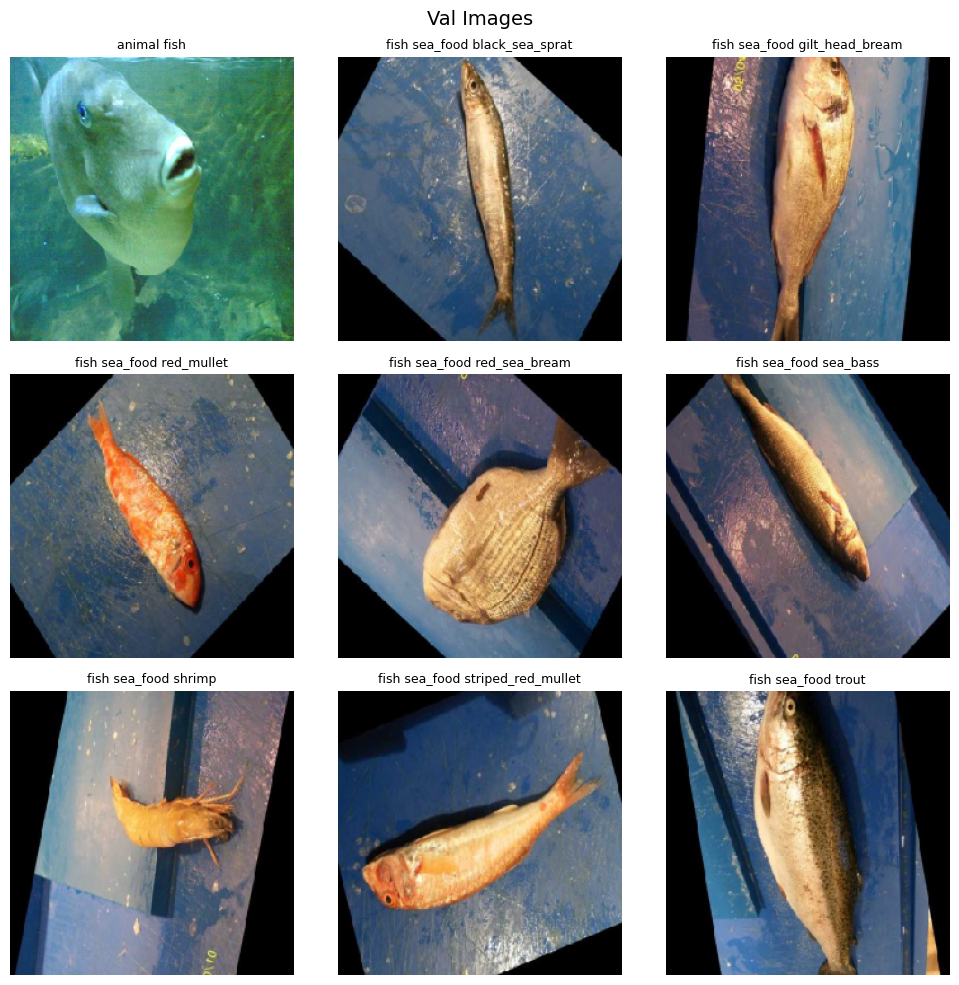

In [12]:
# Map index to class name
index_to_class = {v: k for k, v in val_generator.class_indices.items()}
num_classes = len(index_to_class)

# Limit to 9 classes for 3x3 display
max_display = min(9, num_classes)

# Dictionary to store one image per class
sample_images = {}

# Collect one image per class
for images, labels in val_generator:
    label_indices = np.argmax(labels, axis=1)

    for img, idx in zip(images, label_indices):
        if idx not in sample_images:
            sample_images[idx] = img
        if len(sample_images) == max_display:
            break
    if len(sample_images) == max_display:
        break

# Plot in 3x3 grid
plt.figure(figsize=(10, 10))
for i, (class_idx, image) in enumerate(sorted(sample_images.items())[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(index_to_class[class_idx], fontsize=9)
    plt.axis("off")

plt.suptitle("Val Images", fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the feature map before feeding into Dense layers
    layers.Flatten(),
    
    # Fully connected layers with Dropout
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Further regularization
    
    # Output layer for multi-class classification (softmax activation)
    layers.Dense(train_generator.num_classes, activation='softmax')  # Change 10 to your number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical_crossentropy if labels are one-hot encoded
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_97 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,247,499 (84.87 MB)

 Trainable params: 22,247,499 (84.87 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 166s 843ms/step - accuracy: 0.2937 - loss: 2.0815 - val_accuracy: 0.6951 - val_loss: 0.9573
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6205 - loss: 1.0659 - val_accuracy: 0.7885 - val_loss: 0.6631
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.7393 - loss: 0.7587 - val_accuracy: 0.8516 - val_loss: 0.4535
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.8145 - loss: 0.5537 - val_accuracy: 0.8480 - val_loss: 0.4159
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 159s 816ms/step - accuracy: 0.8555 - loss: 0.4269 - val_accuracy: 0.9341 - val_loss: 0.2243
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 163s 835ms/step - accuracy: 0.8805 - loss: 0.3532 - val_accuracy: 0.9277 - val_loss: 0.2366
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 166s 848ms/step - accuracy: 0.8684 - loss: 0.3896 - val_accuracy: 0.9341 - val_loss: 0.2031
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 159s 814ms/step - accuracy: 0.9078 - loss: 0.

In [15]:
model.save("models/cnn_finetuned.h5")

In [24]:
results["cnn"]=history.history

In [25]:
import json
with open("reports/training_history.json", "w") as f:
    json.dump(history.history, f, indent=4)

print("✅ Training history saved to reports/training_history.json")

✅ Training history saved to reports/training_history.json


In [ ]:
# Load model and training history
model = load_model("models/cnn_finetuned.h5")
with open("reports/training_history.json","r") as f:
    history = json.load(f)

# Directories
test_dir = "C:/Users/conta/OneDrive/Desktop/Multiclass/data/test"

# Load test data
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Predict
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

# 1. Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label="Train")
plt.plot(history['val_accuracy'], label="Val")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label="Train")
plt.plot(history['val_loss'], label="Val")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("reports/training_curves.png")
plt.close()

# 2. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("reports/cnn_confusion_matrix.png")
plt.close()

# 3. Classification report & accuracy
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

acc = accuracy_score(y_true, y_pred)
print(f"\nOverall Test Accuracy: {acc:.2%}")

# 4. Prediction CSV
filenames = test_generator.filenames
df_results = pd.DataFrame({
    "Image": filenames,
    "True_Label": [class_labels[i] for i in y_true],
    "Predicted_Label": [class_labels[i] for i in y_pred]
})
csv_path = os.path.join("predictions", "cnn_test_predictions.csv")
df_results.to_csv(csv_path, index=False)

Found 3187 images belonging to 11 classes.
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step
Classification Report:

                                  precision    recall  f1-score   support

                     animal fish       0.97      0.99      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.95      1.00      0.97       298
   fish sea_food gilt_head_bream       0.97      0.88      0.92       305
   fish sea_food hourse_mackerel       1.00      0.98      0.99       286
        fish sea_food red_mullet       0.89      1.00      0.94       291
     fish sea_food red_sea_bream       0.95      0.93      0.94       273
          fish sea_food sea_bass       0.92      0.96      0.94       327
            fish sea_food shrimp       0.99      0.99      0.99       289
fish sea_food striped_red_mullet       0.99      0.87      0.93       293
             fish sea_food trout       0.95      1.00      0.97       292


In [32]:
import shutil
output_dir = "C:/Users/conta/OneDrive/Desktop/Multiclass/predictions"

# Map class indices
class_labels = list(test_generator.class_indices.keys())
filenames = test_generator.filenames
y_true = test_generator.classes

# Predict
pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)

# Create output folders
for label in class_labels:
    os.makedirs(os.path.join(output_dir, 'correct', label), exist_ok=True)
    for pred in class_labels:
        os.makedirs(os.path.join(output_dir, 'incorrect', label, pred), exist_ok=True)

# Copy images to corresponding folders
for i, (filename, true, pred) in enumerate(zip(filenames, y_true, y_pred)):
    src_path = os.path.join(test_dir, filename)
    if true == pred:
        dst_path = os.path.join(output_dir, 'correct', class_labels[true], os.path.basename(filename))
    else:
        dst_path = os.path.join(output_dir, 'incorrect', class_labels[true], class_labels[pred], os.path.basename(filename))
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy2(src_path, dst_path)

print("✅ Organized predictions into correct/ and incorrect/ folders.")


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step
✅ Organized predictions into correct/ and incorrect/ folders.


#### Experiment with five pre-trained models (e.g., VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0).

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import (
    VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
)
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_pre
from tensorflow.keras.applications.resnet50 import preprocess_input as res_pre
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mob_pre
from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_pre
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_pre

# 🔁 Function to get model + preprocessor
def get_model_and_preprocessor(name):
    if name == "VGG16":
        return VGG16, vgg_pre
    elif name == "ResNet50":
        return ResNet50, res_pre
    elif name == "MobileNetV2":
        return MobileNetV2, mob_pre
    elif name == "InceptionV3":
        return InceptionV3, inc_pre
    elif name == "EfficientNetB0":
        return EfficientNetB0, eff_pre

# 🧪 Dataset paths
train_dir = "C:/Users/conta/OneDrive/Desktop/Multiclass/data/train"
val_dir = "C:/Users/conta/OneDrive/Desktop/Multiclass/data/val"
img_size = (224, 224)
batch_size = 32
epochs = 5

# 📦 Models to compare
model_names = ["VGG16", "ResNet50", "MobileNetV2", "InceptionV3", "EfficientNetB0"]
#model_names = ["EfficientNetB0"]
results = {}

for name in model_names:
    print(f"\n🔧 Training {name}...")

    base_model_fn, preprocess_fn = get_model_and_preprocessor(name)

    # Data generators
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn,
                                       rotation_range=30,
                                       zoom_range=0.2,
                                       horizontal_flip=True)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)

    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
    )
    val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
    )

    # ⚙️ Load base model
    base_model = base_model_fn(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    base_model.trainable = False

    # 🔗 Build transfer learning model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(train_gen.num_classes, activation='softmax')
    ])
    #optimizer=optimizers.Adam(1e-4)
    model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # 🚦 Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
    )

    # 🧾 Store results
    results[name] = history.history

    # 💾 Save model
    model.save(os.path.join("models", f"{name.lower()}_finetuned.h5"))


🔧 Training VGG16...
Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 1877s 10s/step - accuracy: 0.5724 - loss: 2.2915 - val_accuracy: 0.9652 - val_loss: 0.1526
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 2091s 11s/step - accuracy: 0.8881 - loss: 0.3382 - val_accuracy: 0.9698 - val_loss: 0.0804
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 730s 4s/step - accuracy: 0.9367 - loss: 0.1965 - val_accuracy: 0.9799 - val_loss: 0.0457
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 579s 3s/step - accuracy: 0.9466 - loss: 0.1535 - val_accuracy: 0.9945 - val_loss: 0.0238
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 590s 3s/step - accuracy: 0.9571 - loss: 0.1245 - val_accuracy: 0.9890 - val_loss: 0.0397



🔧 Training ResNet50...
Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.7018 - loss: 0.9573 - val_accuracy: 0.9853 - val_loss: 0.0576
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.9468 - loss: 0.1527 - val_accuracy: 0.9918 - val_loss: 0.0281
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.9702 - loss: 0.0931 - val_accuracy: 0.9890 - val_loss: 0.0300
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.9688 - loss: 0.0843 - val_accuracy: 0.9927 - val_loss: 0.0208
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.9811 - loss: 0.0561 - val_accuracy: 0.9954 - val_loss: 0.0135



🔧 Training MobileNetV2...
Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 115s 575ms/step - accuracy: 0.7155 - loss: 0.9091 - val_accuracy: 0.9670 - val_loss: 0.1041
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 113s 582ms/step - accuracy: 0.9544 - loss: 0.1378 - val_accuracy: 0.9799 - val_loss: 0.0796
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 1377s 7s/step - accuracy: 0.9704 - loss: 0.1003 - val_accuracy: 0.9844 - val_loss: 0.0520
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 109s 559ms/step - accuracy: 0.9717 - loss: 0.0844 - val_accuracy: 0.9835 - val_loss: 0.0625
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 112s 576ms/step - accuracy: 0.9807 - loss: 0.0644 - val_accuracy: 0.9863 - val_loss: 0.0352



🔧 Training InceptionV3...
Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 1386s 7s/step - accuracy: 0.6180 - loss: 1.2150 - val_accuracy: 0.9350 - val_loss: 0.2382
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 152s 778ms/step - accuracy: 0.8882 - loss: 0.3555 - val_accuracy: 0.9505 - val_loss: 0.1652
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 950s 5s/step - accuracy: 0.9096 - loss: 0.2691 - val_accuracy: 0.9542 - val_loss: 0.1373
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 1928s 10s/step - accuracy: 0.9173 - loss: 0.2437 - val_accuracy: 0.9606 - val_loss: 0.1146
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9248 - loss: 0.2118 - val_accuracy: 0.9725 - val_loss: 0.0857



🔧 Training EfficientNetB0...
Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 171s 830ms/step - accuracy: 0.7588 - loss: 0.7929 - val_accuracy: 0.9899 - val_loss: 0.0585
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 1327s 7s/step - accuracy: 0.9719 - loss: 0.0890 - val_accuracy: 0.9918 - val_loss: 0.0293
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 156s 801ms/step - accuracy: 0.9804 - loss: 0.0610 - val_accuracy: 0.9927 - val_loss: 0.0177
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 612s 3s/step - accuracy: 0.9882 - loss: 0.0370 - val_accuracy: 0.9918 - val_loss: 0.0214
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9912 - loss: 0.0286 - val_accuracy: 0.9954 - val_loss: 0.0141


In [27]:
import json
with open("reports/model_training_results.json", "w") as f:
    json.dump(results, f)

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import sys


# Step 1: Load VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Step 2: Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 3: Checkpoint
os.makedirs('models', exist_ok=True)
checkpoint_path = 'models/vgg16_model.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Step 4: Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint]
)

# Step 5: Save training curves
def plot_training(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('VGG16 Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('VGG16 Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('models/vgg16_model_training_curves.png')
    plt.show()

plot_training(history)

# Step 6: Save training history
with open('models/vgg16_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Step 7: Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.2f}")

# Step 8: Classification Report & Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4150 - loss: 2.2781

195/195 ━━━━━━━━━━━━━━━━━━━━ 778s 4s/step - accuracy: 0.4157 - loss: 2.2740 - val_accuracy: 0.9020 - val_loss: 0.5459
Epoch 2/10
145/195 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - accuracy: 0.6943 - loss: 0.8468

In [32]:
def evaluate_from_combined_json(model_name, model_path, history_json_path, test_dir, report_prefix=""):
    # Load model
    model = load_model(model_path)

    # Load combined history JSON
    with open(history_json_path, "r") as f:
        full_history = json.load(f)
    
    if model_name not in full_history:
        print(f"⚠️ History for model '{model_name}' not found in {history_json_path}")
        return

    history = full_history[model_name]

    # Prepare test data
    test_gen = ImageDataGenerator(rescale=1. / 255)
    test_generator = test_gen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    class_labels = list(test_generator.class_indices.keys())

    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\nTest Accuracy: {test_acc:.2f}")

    # Predict
    pred_probs = model.predict(test_generator)
    y_pred = np.argmax(pred_probs, axis=1)
    y_true = test_generator.classes

    # 📈 Accuracy & Loss Curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label="Train")
    plt.plot(history['val_accuracy'], label="Val")
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label="Train")
    plt.plot(history['val_loss'], label="Val")
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"reports/{report_prefix}_training_curves.png")
    plt.close()

    # 📉 Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"reports/{report_prefix}_confusion_matrix.png")
    plt.close()

    # 📊 Classification Report
    print(f"\n📊 Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))
    acc = accuracy_score(y_true, y_pred)
    print(f"✅ Overall Test Accuracy: {acc:.2%}\n")

    # 📁 Save Predictions
    filenames = test_generator.filenames
    df_results = pd.DataFrame({
        "Image": filenames,
        "True_Label": [class_labels[i] for i in y_true],
        "Predicted_Label": [class_labels[i] for i in y_pred]
    })
    csv_path = os.path.join("predictions", f"{report_prefix}_test_predictions.csv")
    df_results.to_csv(csv_path, index=False)
    print(f"📁 Results saved to: {csv_path}")

In [33]:
evaluate_from_combined_json(
    model_name="VGG16",
    model_path="models/vgg16_finetuned.h5",
    history_json_path="reports/model_training_results.json",
    test_dir="C:/Users/conta/OneDrive/Desktop/Multiclass/data/test",
    report_prefix="VGG16"
)

Found 3187 images belonging to 11 classes.
100/100 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.4507 - loss: 1.8452

Test Accuracy: 0.16
100/100 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step

📊 Classification Report for VGG16:

                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0

In [20]:
evaluate_from_combined_json(
    model_name="InceptionV3",
    model_path="models/inceptionv3_finetuned.h5",
    history_json_path="reports/model_training_results.json",
    test_dir="C:/Users/conta/OneDrive/Desktop/Multiclass/data/test",
    report_prefix="InceptionV3"
)

Found 3187 images belonging to 11 classes.
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 544ms/step

📊 Classification Report for InceptionV3:

                                  precision    recall  f1-score   support

                     animal fish       0.98      1.00      0.99       520
                animal fish bass       1.00      0.46      0.63        13
   fish sea_food black_sea_sprat       0.98      0.98      0.98       298
   fish sea_food gilt_head_bream       0.97      1.00      0.98       305
   fish sea_food hourse_mackerel       0.95      1.00      0.97       286
        fish sea_food red_mullet       1.00      0.89      0.94       291
     fish sea_food red_sea_bream       1.00      0.99      0.99       273
          fish sea_food sea_bass       0.97      0.93      0.95       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.89      0.96      0.92       293
             fish sea_food trout       0.98      1.00  

In [21]:
evaluate_from_combined_json(
    model_name="ResNet50",
    model_path="models/resnet50_finetuned.h5",
    history_json_path="reports/model_training_results.json",
    test_dir="C:/Users/conta/OneDrive/Desktop/Multiclass/data/test",
    report_prefix="ResNet50"
)

Found 3187 images belonging to 11 classes.
100/100 ━━━━━━━━━━━━━━━━━━━━ 98s 966ms/step

📊 Classification Report for ResNet50:

                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00     

In [22]:
evaluate_from_combined_json(
    model_name="MobileNetV2",
    model_path="models/mobilenetv2_finetuned.h5",
    history_json_path="reports/model_training_results.json",
    test_dir="C:/Users/conta/OneDrive/Desktop/Multiclass/data/test",
    report_prefix="MobileNetV2"
)

Found 3187 images belonging to 11 classes.
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 362ms/step

📊 Classification Report for MobileNetV2:

                                  precision    recall  f1-score   support

                     animal fish       0.98      1.00      0.99       520
                animal fish bass       1.00      0.23      0.38        13
   fish sea_food black_sea_sprat       0.96      0.99      0.98       298
   fish sea_food gilt_head_bream       0.98      0.97      0.98       305
   fish sea_food hourse_mackerel       1.00      0.93      0.97       286
        fish sea_food red_mullet       1.00      0.66      0.79       291
     fish sea_food red_sea_bream       0.99      1.00      0.99       273
          fish sea_food sea_bass       0.90      1.00      0.95       327
            fish sea_food shrimp       0.99      0.99      0.99       289
fish sea_food striped_red_mullet       0.73      0.96      0.83       293
             fish sea_food trout       1.00      0.93  

In [31]:
evaluate_from_combined_json(
    model_name="EfficientNetB0",
    model_path="models/efficientnetb0_finetuned.h5",
    history_json_path="reports/model_training_results.json",
    test_dir="C:/Users/conta/OneDrive/Desktop/Multiclass/data/test",
    report_prefix="EfficientNetB0"
)


Found 3187 images belonging to 11 classes.
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 615ms/step

📊 Classification Report for EfficientNetB0:

                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.0